## Homework

Download IBM, McDonalds and Microsoft stock price data for a period of '2017-07-01','2020-06-30' and calculate VaR curves for a portfolio (with weights $w_i=1/p_i$) using different approaches:

1. Use multivariate normal (as in the class)
2. Use Historical simulation (modify the implementation from the univariate case)
3. For both approaches, calculate ES curves and plot them as well (take conditional mean, not the single quantile)
4. Optionally, backtest ES

Then plot all VaR and ES curves on one graph and conduct tests to select the most convenient approach. Finally, you should deliver:
1. One graph with daily historical returns and VaR and ES curves
2. p-value for each model you use for VaR tests
3. Optionally, p-value for each model you use for ES tests
4. Conclusion about what approach is the most suitable for this portfolio

In [71]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
# plt.style.use(['seaborn-darkgrid'])
plt.rcParams['font.family'] = 'DejaVu Sans'
# %config InlineBackend.figure_formats=["png"]

## Data

### Upload and visualize data

In [72]:
import yfinance as yf

selected_companies = ['IBM', 'MCD' ,'MSFT']

data = yf.download(selected_companies, '2017-07-01','2020-06-30' , group_by="column")

data.head()

[*********************100%***********************]  3 of 3 completed


Adj Close                              Close              \
                   IBM         MCD       MSFT         IBM         MCD   
Date                                                                    
2017-06-30  126.135620  138.243210  64.966385  153.830002  153.160004   
2017-07-03  127.570557  137.647522  64.250069  155.580002  152.500000   
2017-07-05  126.004456  138.161987  65.107742  153.669998  153.070007   
2017-07-06  124.930267  138.180008  64.627083  152.360001  153.089996   
2017-07-07  125.405846  141.050339  65.465904  152.940002  156.270004   

                             High                                Low  \
                 MSFT         IBM         MCD       MSFT         IBM   
Date                                                                   
2017-06-30  68.930000  154.500000  153.770004  69.379997  153.139999   
2017-07-03  68.169998  156.029999  153.869995  69.599998  153.520004   
2017-07-05  69.080002  155.889999  153.570007  69.440002  153.630005   
2017-07-06  68.570000  153.830002  153.460007  68.779999  152.229996   
2017-07-07  69.459999  153.490005  156.559998  69.839996  152.139999   

                                         Open                          Volume  \
                   MCD       MSFT         IBM         MCD       MSFT      IBM   
Date                                                                            
2017-06-30  152.720001  68.739998  154.279999  153.300003  68.779999  3571500   
2017-07-03  152.479996  68.019997  153.580002  153.440002  69.330002  2822500   
2017-07-05  151.990005  68.220001  155.770004  152.820007  68.260002  3564400   
2017-07-06  152.330002  68.120003  153.360001  152.699997  68.269997  2757500   
2017-07-07  153.149994  68.699997  152.619995  153.369995  68.699997  2460100   

                               
                MCD      MSFT  
Date                           
2017-06-30  2508200  24161100  
2017-07-03  1100700  16165500  
2017-07-05  2497300  21176300  
2017-07-06  2019800  21117600  
2017-07-07  4117800  16878300

In [73]:
prices = data['Adj Close'].dropna()

print(prices.shape)
prices.head()

(754, 3)


,IBM,MCD,MSFT
Date,,,
2017-06-30,126.135620,138.243210,64.966385
2017-07-03,127.570557,137.647522,64.250069
2017-07-05,126.004456,138.161987,65.107742
2017-07-06,124.930267,138.180008,64.627083
2017-07-07,125.405846,141.050339,65.465904


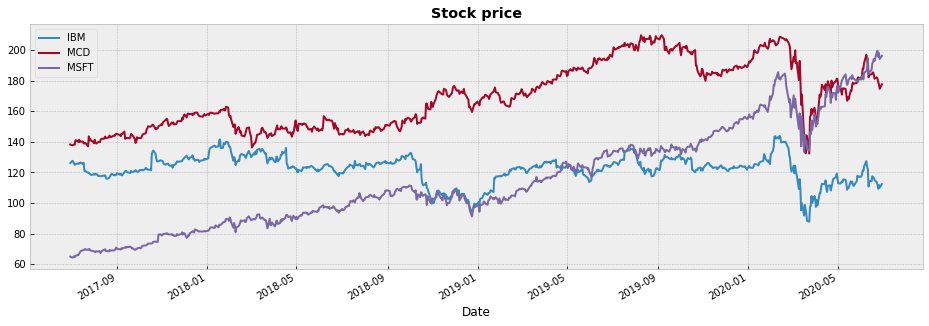

In [74]:
prices.loc[:,selected_companies].plot(figsize=(16, 5))
plt.title("Stock price", weight="bold")

plt.show()

### Preprocess prices and transform to returns

Convert datetime index to period

In [75]:
print(prices.index)

prices.index = prices.index.to_period(freq='d')

print(prices.index)

DatetimeIndex(['2017-06-30', '2017-07-03', '2017-07-05', '2017-07-06',
               '2017-07-07', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14',
               ...
               '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-29'],
              dtype='datetime64[ns]', name='Date', length=754, freq=None)
PeriodIndex(['2017-06-30', '2017-07-03', '2017-07-05', '2017-07-06',
             '2017-07-07', '2017-07-10', '2017-07-11', '2017-07-12',
             '2017-07-13', '2017-07-14',
             ...
             '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
             '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
             '2020-06-26', '2020-06-29'],
            dtype='period[D]', name='Date', length=754)


In [76]:
returns = prices.pct_change().dropna()

returns.head()

,IBM,MCD,MSFT
Date,,,
2017-07-03,0.011376,-0.004309,-0.011026
2017-07-05,-0.012276,0.003738,0.013349
2017-07-06,-0.008525,0.000130,-0.007383
2017-07-07,0.003807,0.020772,0.012979
2017-07-10,0.003138,-0.004799,0.007486


### Plot histograms

<Figure size 504x504 with 0 Axes>

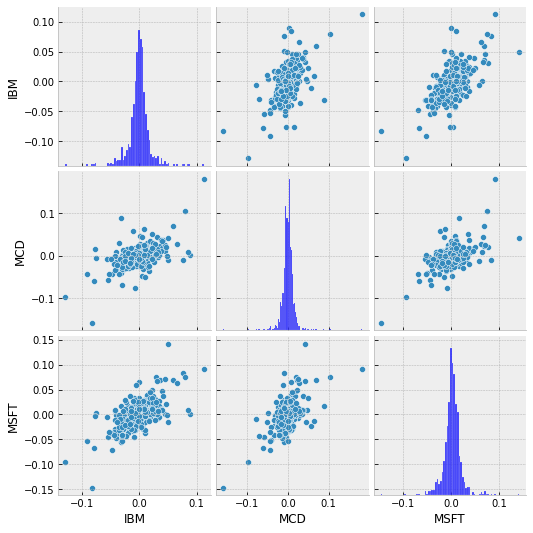

In [77]:
fig = plt.figure(figsize=(7, 7))

sns.pairplot(returns[selected_companies])

plt.show()

In [78]:
w = 1 / prices.iloc[0]
w = w / w.sum()
portfolio_real_returns = np.dot(returns.values, w)
portfolio_real_returns = pd.Series(portfolio_real_returns, index=returns.index)
print(w)

IBM     0.259473
MCD     0.236748
MSFT    0.503780
Name: 2017-06-30, dtype: float64


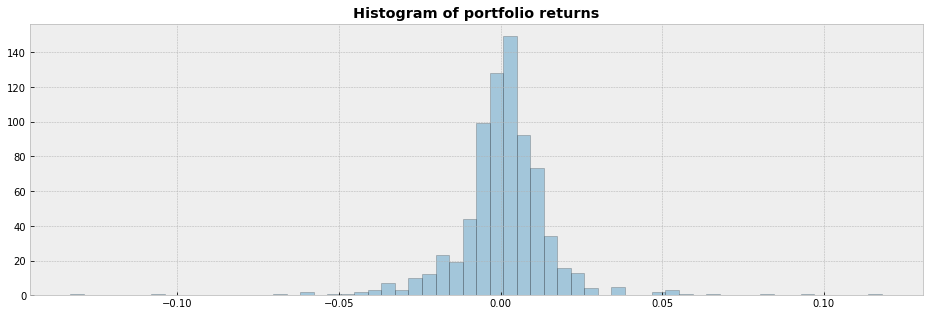

In [80]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of portfolio returns", weight="bold")

plt.show()

# Calculate VaR curves for a portfolio using different approaches

###  Multivariate Normal distribution and HS


In [81]:
import scipy.stats as ss

def make_dummy_HS_simulations(portfolio_real_returns, alpha=0.05):
    return portfolio_real_returns.quantile(alpha)


In [92]:
def make_mult_normal_simulations(returns, n_samples=10**3):

    mean = np.mean(returns.values, axis=0)
    cov = np.cov(returns.values, rowvar=False)

    return_simulations = ss.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations

In [98]:
def calc_VaR(r, sampling_fun, w, L_history=252, level=0.05):
    VaR = np.full(r.shape[0], np.nan)
    ES = np.full(r.shape[0], np.nan)
    
    for i in range(L_history, r.shape[0]):
        history = r[i - L_history: i]
        
        try:
            return_simulations = sampling_fun(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)

            VaR[i] = np.quantile(portfolio_simulated_returns, level)
                        
        except:
            VaR[i] = VaR[i-1]
           
        
    return pd.Series(data=VaR, index=r.index, name=sampling_fun.__name__) 


VaR_multy_normal = calc_VaR(returns, make_mult_normal_simulations, w)
VaR_HS = calc_VaR(returns, make_dummy_HS_simulations, w)

In [120]:
def calc_ES(r, sampling_fun, w, L_history=252, level=0.05):
    ES = np.full(r.shape[0], np.nan)
    
    for i in range(L_history, r.shape[0]):
        history = r[i - L_history: i]
        
        try:
            return_simulations = sampling_fun(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)

            ES[i] = portfolio_simulated_returns[portfolio_simulated_returns<np.quantile(portfolio_simulated_returns, level)].mean()
                        
        except:
            ES[i] = ES[i-1]
           
        
    return pd.Series(data=ES, index=r.index, name=sampling_fun.__name__) 

ES_multy_normal = calc_ES(returns, make_mult_normal_simulations, w)
ES_HS = calc_ES(returns, make_dummy_HS_simulations, w)

C:\Users\hiimm\AppData\Local\Temp/ipykernel_18572/2191904121.py:11: RuntimeWarning: Mean of empty slice.
  ES[i] = portfolio_simulated_returns[portfolio_simulated_returns<np.quantile(portfolio_simulated_returns, level)].mean()
C:\Users\hiimm\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


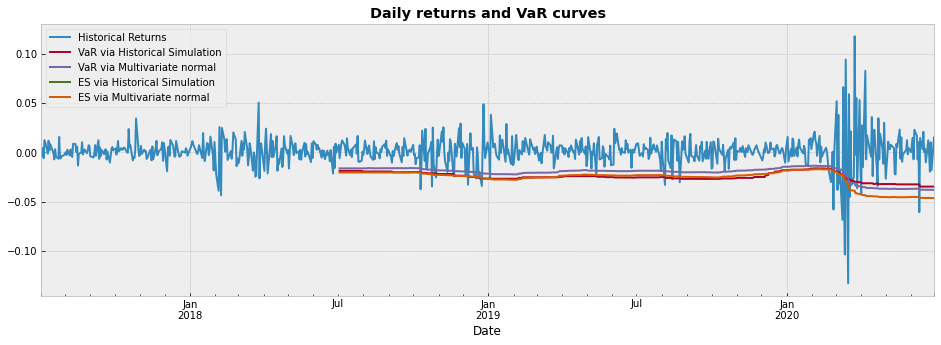

In [121]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns.plot()

VaR_HS.plot()
VaR_multy_normal.plot()

ES_HS.plot()
ES_multy_normal.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
           'VaR via Multivariate normal',
            'ES via Historical Simulation',
           'ES via Multivariate normal',
           ])

plt.show()